In [1]:
import pandas as pd
import numpy as np
import time
import re
import operator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../dataset/TBN_CIF.csv", header=0)
sd = pd.read_csv("../dataset/TBN_Y_ZERO.csv", header=0)
df.head()

CUST_NO  AGE  CHILDREN_CNT  CUST_START_DT  EDU_CODE GENDER_CODE  \
0  UFUIMEGMK2KTIWI4    1           NaN            2.0       NaN         NaN   
1  3HJN2X_LGBHBKILI    3           0.0         9393.0       NaN         NaN   
2  MNEZK2O3OE-JHYBW    4           0.0         2912.0       3.0           M   
3  W7ADZSWYXEMHB7JQ    4           0.0         8332.0       5.0           M   
4  ODB6BA6ORHL2UYZE    4           0.0          744.0       3.0           M   

   INCOME_RANGE_CODE  WORK_MTHS  
0                NaN        NaN  
1                1.0        NaN  
2                2.0        2.0  
3                2.0        1.0  
4                2.0        1.0

In [3]:
#1. 分析數據
df.describe()
#總共 : 187679
#AGE : 0 缺失
#CHILDREN_CNT : 432 缺失
#CUST_START_DT : 0 缺失
#EDU_CODE : 28,988 缺失
#INCOME_RANGE_CODE : 382 缺失
#WORK_MTHS : 36,190 缺失

AGE   CHILDREN_CNT  CUST_START_DT       EDU_CODE  \
count  187679.000000  187247.000000  187679.000000  158691.000000   
mean        2.511053       0.023509    6260.023998       3.632077   
std         1.105938       0.224682    2385.903856       1.211771   
min         1.000000       0.000000       0.000000       1.000000   
25%         2.000000       0.000000    4296.000000       3.000000   
50%         3.000000       0.000000    6747.000000       3.000000   
75%         3.000000       0.000000    8367.000000       5.000000   
max         4.000000      10.000000    9567.000000       6.000000   

       INCOME_RANGE_CODE      WORK_MTHS  
count      187297.000000  151489.000000  
mean            1.208236       1.058757  
std             0.536134       0.238984  
min             1.000000       1.000000  
25%             1.000000       1.000000  
50%             1.000000       1.000000  
75%             1.000000       1.000000  
max             4.000000       5.000000

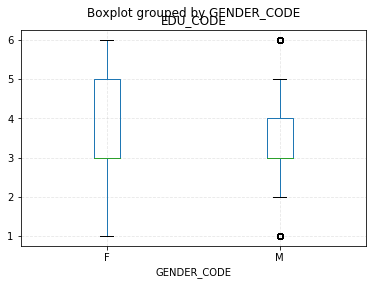

In [4]:
df.boxplot(column='EDU_CODE', by='GENDER_CODE')
plt.grid(linestyle='--',alpha=0.3)
plt.show()

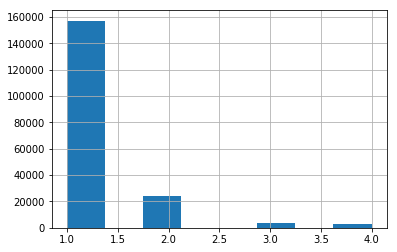

In [5]:
df['INCOME_RANGE_CODE'].hist(bins=8)
plt.show()

In [6]:
#2. 產生測試資料 2018/01
tfCIF = df.drop(["CHILDREN_CNT","INCOME_RANGE_CODE","WORK_MTHS","GENDER_CODE"], axis=1) #去除不必要資料
tfCIF = tfCIF.dropna() #有缺失值的都刪除
tfCIF.head()

CUST_NO  AGE  CUST_START_DT  EDU_CODE
2  MNEZK2O3OE-JHYBW    4         2912.0       3.0
3  W7ADZSWYXEMHB7JQ    4         8332.0       5.0
4  ODB6BA6ORHL2UYZE    4          744.0       3.0
5  SURN2CDMNHCL4SJC    4         4677.0       2.0
6  1SMBYIP5SSUNG1DW    4         7936.0       6.0

In [7]:
#加欄位
tf = pd.concat(
    [
        tfCIF,
        pd.DataFrame(
            [[0,0,0,0,0,0,0,0]], 
            index=tfCIF.index, 
            columns=['LN_READ_1', 'LN_READ_2', 'LN_READ_3', 'LN_READ_4', 'LN_PREDICT_2', 'LN_PREDICT_3', 'LN_PREDICT_4', 'LN_PREDICT_5']
        )
    ], axis=1
)
tf.head()

CUST_NO  AGE  CUST_START_DT  EDU_CODE  LN_READ_1  LN_READ_2  \
2  MNEZK2O3OE-JHYBW    4         2912.0       3.0          0          0   
3  W7ADZSWYXEMHB7JQ    4         8332.0       5.0          0          0   
4  ODB6BA6ORHL2UYZE    4          744.0       3.0          0          0   
5  SURN2CDMNHCL4SJC    4         4677.0       2.0          0          0   
6  1SMBYIP5SSUNG1DW    4         7936.0       6.0          0          0   

   LN_READ_3  LN_READ_4  LN_PREDICT_2  LN_PREDICT_3  LN_PREDICT_4  \
2          0          0             0             0             0   
3          0          0             0             0             0   
4          0          0             0             0             0   
5          0          0             0             0             0   
6          0          0             0             0             0   

   LN_PREDICT_5  
2             0  
3             0  
4             0  
5             0  
6             0

In [8]:
#9448~9567  (2017/12/28~2018/4/27)
#----------------------------------
#9448~9477  (2017/12/28~2018/1/27) LN_READ_1
#9478~9507  (2018/1/28~2018/2/27)  LN_READ_2, LN_PREDICT_2
#9408~9537  (2018/2/28~2018/3/27)  LN_READ_3, LN_PREDICT_3
#9438~9567  (2018/3/28~2018/4/27)  LN_READ_4, LN_PREDICT_4
#--------------------------------
#9568~9597  (2018/4/28~2018/5/27)  LN_PREDICT_5
start = time.time()
READ = pd.read_csv("../dataset/TBN_CUST_BEHAVIOR_TRAN.csv", header=0) #瀏覽網頁資料 客戶行為訓練
READ.loc[(READ.VISITDATE>=9448) & (READ.VISITDATE<=9477),'VISITDATE'] = 1
READ.loc[(READ.VISITDATE>=9478) & (READ.VISITDATE<=9507),'VISITDATE'] = 2
READ.loc[(READ.VISITDATE>=9508) & (READ.VISITDATE<=9537),'VISITDATE'] = 4
READ.loc[(READ.VISITDATE>=9538) & (READ.VISITDATE<=9567),'VISITDATE'] = 8
end = time.time()
print("花費時間:",end-start)

花費時間: 3.4098961353302


In [9]:
start = time.time()
def cal_LN_READ(row):
    if re.match(r"^(?!.*house).*loan.*", row["PAGE//"]):
        row["PAGE//"] = 1
    else:
        row["PAGE//"] = 0
    return row
READ = READ.apply(cal_LN_READ, axis=1)
end = time.time()
print("花費時間:",end-start)
READ.head()

花費時間: 364.9222707748413


CUST_NO  VISITDATE  PAGE//
0  AZTHNWQ_LXMGIMYG          1       0
1  AZTHNWQ_LXMGIMYG          4       0
2  3PY428CHUQBULFIG          1       0
3  JVPD1QUJWVLMZU8S          1       0
4  JVPD1QUJWVLMZU8S          2       0

In [10]:
#查看不同PAGE//個數 --> loan 16萬(不包含房貸)
temp1=READ['PAGE//'].value_counts(ascending=True)
temp1
#取有值的
READ1 = READ[READ["PAGE//"] > 0]
READ1.head()

CUST_NO  VISITDATE  PAGE//
9   6STXUMWZRDCGSDDU          2       1
10  YV7EFLVIAQER2KRU          2       1
39  U7SFOZSXFCIPAJV4          4       1
46  XOU4AV774LAWP_K4          4       1
47  XOU4AV774LAWP_K4          4       1

In [11]:
#當成hash跑比較快
start = time.time()
d_read = dict()
for index, row in READ1.iterrows():
    if (row["CUST_NO"] in d_read.keys()):
        if row["VISITDATE"] == 1:
            d_read[row["CUST_NO"]] |= 1
        elif row["VISITDATE"] == 2:
            d_read[row["CUST_NO"]] |= 2
        elif row["VISITDATE"] == 4:
            d_read[row["CUST_NO"]] |= 4
        elif row["VISITDATE"] == 8:
            d_read[row["CUST_NO"]] |= 8            
    else:
        d_read[row["CUST_NO"]] = row["VISITDATE"]
for i in d_read: #有些人不同季信貸
    if d_read[i] > 9:
        print(i)
end = time.time()
print("花費時間:",end-start)

HWAZJ_IO2-GACG_C
W9YD0FJGPZPYH06E
MTTHSGUQVFZBC5UQ
WDFQY9V8JLCQQJ5U
NS5LP8Q_XT-Q5F-I
ZDEGKJZ6J21-Z9ZY
NQ9TNJUQSNPDH-E4
HK1OZNNCGOCH3HRQ
RALJ_U9M-T3XV3VU
CDD9ZPBFZGHIBRHA
DDFRANFNP2O4QOY0
KUKBQGZ0KKFKQCKG
EMRNXDAQV8MRCWLA
TLQIXA_-U-QCJWYS
IIPLNV5JGJYXMFIC
YU3PIYKDRGIINPFC
ZLVKIEVO5QTEFR_C
XH3BFK27JL2F0THE
UWU5OPE6S5ARG7NK
JCF_UT8TGQW7D26W
ZIBLPFYEMYJMQQW4
VIBYMTSYMISEGO5E
IGREH1SLA_HFPF98
X4-WT7HDJNYH5BE8
S3-WFVAIYZ23UOLO
J9GNEEUH0GLMMN1C
RI_-8Y8UMFWE1KNO
5B45_BNVIIJVF8ME
XDGO7JRBGH4HVAQU
7CLREAHBDB7J_OPW
G1UX_5MH3VO1MUM8
PHBBN0-IVRJRCI4K
CZXAYWXKNNF9FF6Y
NE4KS-FPGW8HDN4O
4WO4L-G3MAR5YYLM
KSQHOJEE5CEOKKGG
WZ8C0VE-NIQTV8NQ
CPC5LRVUH2ZR1-LK
RW97_TZCLMKWT79C
YNMUWS9AS8XCUYZO
V8SPSJZBUPIKYRL4
FGKJJK76JJAF7WT8
FACLELYMQFFFCQBM
IZBSQ3QNEHMN9TSC
5YYJ9SYFOFURALRK
OYKY7AGDGVXYQZ9K
GCCCFIZFWBDGJP14
9BOHVXWOULUVMQPM
ONP3JDEXHR3BFR8I
HWNFG-O3OJC1GI-4
RZ6TUGX46B6GDQPE
H-EYBKZHR8TTRJD8
QEOTWIR82B9MEVQS
MTE_CMI5JL4QMQJC
5HAS7SAKAUHYVMJG
QOXJBX7VA-QR2XOG
66GRESUR1E178KTO
RJPJ09QMTBCNQVTK
KKFFGUXTYCXEER

In [12]:
READ1.loc[READ1.CUST_NO == "RAAZN8JK3_IB1VQS"]
# d_read["RAAZN8JK3_IB1VQS"]

CUST_NO  VISITDATE  PAGE//
2009250  RAAZN8JK3_IB1VQS          4       1
2009251  RAAZN8JK3_IB1VQS          4       1
2009252  RAAZN8JK3_IB1VQS          4       1
2122974  RAAZN8JK3_IB1VQS          8       1
2122975  RAAZN8JK3_IB1VQS          8       1
2122976  RAAZN8JK3_IB1VQS          8       1
2122977  RAAZN8JK3_IB1VQS          8       1
2122978  RAAZN8JK3_IB1VQS          8       1
2122979  RAAZN8JK3_IB1VQS          8       1
2122980  RAAZN8JK3_IB1VQS          8       1
2122981  RAAZN8JK3_IB1VQS          8       1
2122982  RAAZN8JK3_IB1VQS          8       1

In [13]:
PREDICT = pd.read_csv("../dataset/TBN_LN_APPLY.csv", header=0) #信貸申請資料 預測資料
PREDICT.loc[(PREDICT.TXN_DT<9478),'TXN_DT'] = 0
PREDICT = PREDICT[PREDICT.TXN_DT > 0]
PREDICT.loc[(PREDICT.TXN_DT>=9478) & (PREDICT.TXN_DT<=9507),'TXN_DT'] = 1
PREDICT.loc[(PREDICT.TXN_DT>=9508) & (PREDICT.TXN_DT<=9537),'TXN_DT'] = 2
PREDICT.loc[(PREDICT.TXN_DT>=9538) & (PREDICT.TXN_DT<=9567),'TXN_DT'] = 4
PREDICT.head()

#當成hash跑比較快
d_predict = dict()
for index, row in PREDICT.iterrows():
    if (row["CUST_NO"] in d_predict.keys()):
        if row["TXN_DT"] == 1:
            d_predict[row["CUST_NO"]] |= 1
        elif row["TXN_DT"] == 2:
            d_predict[row["CUST_NO"]] |= 2
        elif row["TXN_DT"] == 4:
            d_predict[row["CUST_NO"]] |= 4
    else:
        d_predict[row["CUST_NO"]] = row["TXN_DT"]

for i in d_predict: #有些人不同季信貸
    if d_predict[i] > 4:
        print(i)
PREDICT.loc[PREDICT.CUST_NO == "EBQUS_PNHMV8KY6Q"]

F2OZYLJCPNB9CBGC
PRSXPXMVJ_3N5ZCK
MY6SEPVBVAUZ_T3Y
WGB1XXGB-7CYELEC
EBQUS_PNHMV8KY6Q
DRA2RYALQQ_AYCJK
BOFYJINDGJ8YKTE0
ET0QW9WBSOLZRQFU
MW_JUYN7MMFC5S4S
QM6N2MGNLYL2RFPY
JOLGEAXRHZE5CTSG
AG-C0V3BLARL3NBM
SQCFCC5JOFKWN_LK
XEXLTP81HBPNETWG
38MIAQB6FHIE03CE


CUST_NO  TXN_DT  LN_AMT LN_USE
1617  EBQUS_PNHMV8KY6Q       4  988495     06
2940  EBQUS_PNHMV8KY6Q       1  988495     06

In [15]:
###############################test
# temp1=READ['VISITDATE'].value_counts(ascending=True)
# temp1
# if not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 1)].empty):
#     print(1)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 2)].empty):
#     print(2)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 3)].empty):
#     print(3)
# elif not (READ1.loc[(READ1.CUST_NO == "U7SFOZSXFCIPAJV4") & (READ1.VISITDATE == 4)].empty):    
#     print(4)
# else:
#     print(5)
# READ1.loc[(READ1.CUST_NO == "YV7EFLVIAQER2KRU") & (READ1.VISITDATE == 2)].empty
############################test

# READ1.loc[(READ1.CUST_NO == "MNEZK2O3OE-JHYBW")]
# if (d_read["MNEZK2O3OE-JHYBW"] & 1):
#     print(1)
# else:
#     print(2)
# if (row["CUST_NO"] in d_predict.keys()):
#     d_read[row["CUST_NO"]]

In [ ]:
start = time.time()
def cal_LN(row):

    if (row["CUST_NO"] in d_read.keys()):
        if (d_read[row.CUST_NO] & 1):
            row["LN_READ_1"] = 1
        if (d_read[row.CUST_NO] & 2):
            row["LN_READ_2"] = 1
        if (d_read[row.CUST_NO] & 4):
            row["LN_READ_3"] = 1
        if (d_read[row.CUST_NO] & 8):
            row["LN_READ_4"] = 1

    if (row["CUST_NO"] in d_predict.keys()):
        if (d_predict[row.CUST_NO] & 1):
            row["LN_PREDICT_2"] = 1
        if (d_predict[row.CUST_NO] & 2):
            row["LN_PREDICT_3"] = 1
        if (d_predict[row.CUST_NO] & 4):
            row["LN_PREDICT_4"] = 1

    return row
tf = tf.apply(cal_LN, axis=1)
td = tf.drop(["CUST_NO"], axis=1)
end = time.time()
print("花費時間:",end-start)

In [ ]:
td.describe() # training data 準備好

In [ ]:
#查看不同AGE個數
temp1=td['AGE'].value_counts(ascending=True)
temp1

In [ ]:
#2018/1
#分訓練跟測試資料
td1 = td.drop(['LN_READ_2','LN_READ_3','LN_READ_4','LN_PREDICT_3','LN_PREDICT_4','LN_PREDICT_5'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(td1.drop('LN_PREDICT_2', axis=1), td1.LN_PREDICT_2, train_size=0.9, test_size=0.1)

In [ ]:
#演算法-隨機森林
model=RandomForestClassifier()
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

In [ ]:
#2018/2
#分訓練跟測試資料
td2 = td.drop(['LN_READ_3','LN_READ_4','LN_PREDICT_4','LN_PREDICT_5'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(td2.drop('LN_PREDICT_3', axis=1), td2.LN_PREDICT_3, train_size=0.9, test_size=0.1)

In [ ]:
#演算法-隨機森林2
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

In [ ]:
#2018/3
#分訓練跟測試資料
td3 = td.drop(['LN_READ_4','LN_PREDICT_5'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(td3.drop('LN_PREDICT_4', axis=1), td3.LN_PREDICT_4, train_size=0.9, test_size=0.1)

In [ ]:
#演算法-隨機森林3
start=time.time()
model.fit(X_train,y_train)
train_predict=model.predict(X_train)
train_f1=metrics.f1_score(train_predict,y_train)
train_accuracy=metrics.accuracy_score(train_predict,y_train)
train_recall=metrics.recall_score(train_predict,y_train)
print('train f1_mean = %.4f' % train_f1, end='\n')
print('train 精確率   = %.4f' % train_accuracy, end='\n')
print('train 召回率   = %.4f' % train_recall)
test_predict=model.predict(X_test)
test_f1=metrics.f1_score(test_predict,y_test)
test_accuracy=metrics.accuracy_score(test_predict,y_test)
test_recall=metrics.recall_score(test_predict,y_test)
print('='*50)
print('test f1_mean = %.4f' % test_f1, end='\n')
print('test 精確率   = %.4f' % test_accuracy, end='\n')
print('test 召回率   = %.4f' % test_recall)
end=time.time()
print('='*50)
print('花費時間 = %.4f' % (end-start))

In [ ]:
#2018/4 實際資料
td4 = tf.drop(['LN_READ_1','LN_PREDICT_2','LN_PREDICT_5'], axis=1)
td4.to_csv('td4.csv', index= False)
# res = model.predict(td4)
# res

In [ ]:
submit = pd.read_csv('../src/TBN_Y_ZERO_212_v1.csv')
#submit = submit.drop(["FX_IND","FX_IND","LN_IND","WM_IND"], axis=1)
#submit = submit.sort_values(["CUST_NO"])
submit.head(n=5)

In [ ]:
a = pd.read_csv('../dataset_4/td4_4.csv')
a = a.sort_values(["CUST_NO"])
# # count = 0
# insert = pd.DataFrame([[13,0,0,0,0,0,0,0,0]],columns=["CUST_NO","AGE","CUST_START_DT","EDU_CODE","LN_READ_2","LN_READ_3","LN_READ_4","LN_PREDICT_3","LN_PREDICT_4"])
# above = a.iloc[:12]
# below = a.iloc[13:]
# # b = a.iloc[12].append(insert,ignore_index=True).append(14,ignore_index=True)
# # a.loc[:12]
# b = above.append(insert,ignore_index=True).append(below,ignore_index=True)
# # b = a.append([insert], ignore_index=True)
# b
start = time.time()
count = 0
for i in range(len(submit)):
    if a.loc[a.CUST_NO == count].empty:
        insert = pd.DataFrame([[count,0,0,0,0,0,0,0,0]],columns=["CUST_NO","AGE","CUST_START_DT","EDU_CODE","LN_READ_2","LN_READ_3","LN_READ_4","LN_PREDICT_3","LN_PREDICT_4"])
        above = a.iloc[:count]
        below = a.iloc[count:]
        a = above.append(insert,ignore_index=True).append(below,ignore_index=True)
    count+=1

end = time.time()
print("花費時間:",end-start)
a


In [ ]:
final_test = a.drop(["CUST_NO"], axis=1)
#submit = submit.drop(["FX_IND","FX_IND","LN_IND","WM_IND"], axis=1)

res = model.predict(final_test)
res

In [ ]:
count=0
for i in res:
    if i > 0:
        count+=1
print("1有",count,"個")

In [ ]:
submit["LN_IND"] = res
submit.head()
submit.to_csv('submit.csv', index= False)

In [ ]:
feature_importance = model.feature_importances_ #度量特征权重的接口
print(feature_importance) 
#特征的相关属性值
print(feature_importance.max())
#最大特征的属性值
feature_importance=100.0*(feature_importance/feature_importance.max())
index=np.argsort(feature_importance)[-10:] #倒序排列，倒数10个排名
plt.barh(np.arange(10), feature_importance[index], color='dodgerblue', alpha=0.4)
print(np.array(final_test.columns)[index])
plt.yticks(np.arange(10+0.25), np.array(final_test.columns)[index])
plt.xlabel('Relative importance')
plt.title('Top 10 Importance Variable')
plt.show()